In [ ]:
!pip install torchaudio
# !pip install wandb

In [ ]:



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd


import scipy
from scipy import signal
import soundfile as sf

import tensorflow as tf
from tensorflow import keras
from keras import models, layers

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from pathlib import Path
from tqdm import tqdm_notebook
import IPython
import IPython.display
import PIL
import shutil

from tqdm.auto import tqdm
from keras.preprocessing import image

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import random
import pickle
import numpy as np

import torch
# import wandb


import warnings
warnings.simplefilter("ignore", UserWarning)
import time
import datetime
import os
from copy import deepcopy
import json
import sys
import transformers

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchvision import transforms
from torch.optim import AdamW
from torch.utils.data import DataLoader

seed_value = 123

torch.manual_seed(seed_value)

# Set the seed for NumPy
np.random.seed(seed_value)

In [ ]:
!gdown 1aD9Sa8krY5CALUxcrhNBzFIZaXJVYz5l

Downloading...
From: https://drive.google.com/uc?id=1aD9Sa8krY5CALUxcrhNBzFIZaXJVYz5l
To: /content/kaggle.json
100% 75.0/75.0 [00:00<00:00, 332kB/s]


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download vbookshelf/respiratory-sound-database

Dataset URL: https://www.kaggle.com/datasets/vbookshelf/respiratory-sound-database
License(s): unknown
100% 3.68G/3.69G [00:44<00:00, 183MB/s]
100% 3.69G/3.69G [00:44<00:00, 88.1MB/s]


In [ ]:
!gdown 1a4P4rdXqGSKmTNrDIptVFRLDKrd0Ejc-

Downloading...
From: https://drive.google.com/uc?id=1a4P4rdXqGSKmTNrDIptVFRLDKrd0Ejc-
To: /content/ICBHI_challenge_train_test.txt
100% 27.2k/27.2k [00:00<00:00, 80.3MB/s]


In [ ]:
import os
import zipfile
zip_ref = zipfile.ZipFile("./respiratory-sound-database.zip", "r")
zip_ref.extractall("respiratory-sound-database")
zip_ref.close()

In [ ]:
dir = "/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database"
patient_diagnosis_path = dir + '/patient_diagnosis.csv'
filename_format_path = dir+ '/filename_format.txt'
audio_and_txt_files_path = dir+ '/audio_and_txt_files'
official_split_path = '/ICBHI_challenge_train_test.txt'

In [ ]:

# seed =123
# print_freq = 10
# save_freq= 100
# save_dir = './checkpoint'
# tag = 'AST-fine tune'  #tag for experiment name
# resume =  False #path of model checkpoint to resume
# eval = False  #only evaluation with pretrained encoder and classifier
# two_class_eval = False #evaluate with two classes


# optimizer = 'adam'
# epochs = 400
# learning_rate = 1e-3
# lr_decay_epochs = '120, 160'
# lr_decay_rate = 0.1
# weight_decay = 1e-4
# momentum = 0.9
# cosine = False
# warm = False
# wighted_loss = False  #weighted cross entropy loss (higher weights on abnormal class)
# mix_beta = 1.0  #patch-mix interpolation coefficient'
# time_domain = False  # patchmix for the specific time domain

In [ ]:
split_file = '/content/ICBHI_challenge_train_test.txt'
demographic_file = '/content/respiratory-sound-database/demographic_info.txt'
datafold = '/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database'

# Copy the file
shutil.copy(split_file, datafold)
shutil.copy(demographic_file,datafold)

'/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/demographic_info.txt'

In [ ]:
df_diseases = pd.read_csv("/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv",
                 names = ["pid","disease"])
df_diseases.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
train_test_set = pd.read_csv("ICBHI_challenge_train_test.txt", sep = '\t', header = None, names= ['filename', 'split'])
train_test_set.head()

,filename,split
0,101_1b1_Al_sc_Meditron,test
1,101_1b1_Pr_sc_Meditron,test
2,102_1b1_Ar_sc_Meditron,test
3,103_2b2_Ar_mc_LittC2SE,train
4,104_1b1_Al_sc_Litt3200,test


In [ ]:
path = "/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files"
files =[]
files.clear()
for file in os.listdir(path):
  if(file.split(".")[1]=="wav"):
    files.append(file)
print(len(files))
files[:5]

920


['218_1p1_Pl_sc_Litt3200.wav',
 '178_1b3_Pr_mc_AKGC417L.wav',
 '176_2b3_Pr_mc_AKGC417L.wav',
 '209_1b1_Tc_sc_Meditron.wav',
 '203_2p3_Tc_mc_AKGC417L.wav']

In [ ]:
txt_files = []
txt_files.clear()
txt_files = [file.split('.')[0] for file in os.listdir(path) if '.txt' in file]
txt_files[:5]

['151_2p4_Al_mc_AKGC417L',
 '203_1p4_Pr_mc_AKGC417L',
 '186_2b4_Lr_mc_AKGC417L',
 '154_3b3_Ll_mc_AKGC417L',
 '130_2b2_Pr_mc_AKGC417L']

In [ ]:
import pandas as pd

def fileInfo(file):
    return file.split('_')

files_data =[]
for file in txt_files:
    details = fileInfo(file)
    file_info = {
        'pid': details[0],
        'mode': details[3],
        'device': details[4],
        'filename': file
    }
    files_data.append(file_info)
df_filename = pd.DataFrame(files_data)
df_filename.head()

,pid,mode,device,filename
0,151,mc,AKGC417L,151_2p4_Al_mc_AKGC417L
1,203,mc,AKGC417L,203_1p4_Pr_mc_AKGC417L
2,186,mc,AKGC417L,186_2b4_Lr_mc_AKGC417L
3,154,mc,AKGC417L,154_3b3_Ll_mc_AKGC417L
4,130,mc,AKGC417L,130_2b2_Pr_mc_AKGC417L


In [ ]:
print("Train test split set file size", train_test_set.shape)
print("Respiratory Information text file size", df_filename.shape)

Train test split set file size (920, 2)
Respiratory Information text file size (920, 4)


In [ ]:
row_with_filename = train_test_set[train_test_set['filename'].str.startswith('226_')]
print(row_with_filename)

                   filename  split
917  226_1b1_Al_sc_Meditron  train
918  226_1b1_Ll_sc_Meditron  train
919  226_1b1_Pl_sc_Meditron  train


In [ ]:
row_absent_in = df_filename[df_filename['filename']== "226_1b1_Pl_sc_Meditron"]
row_absent_in

,pid,mode,device,filename


In [ ]:
## File name incompatibale with Respiratory Information text file.So, renaming in split file
train_test_set['filename'] = train_test_set['filename'].replace('226_1b1_Pl_sc_Meditron', '226_1b1_Pl_sc_LittC2SE')

In [ ]:
df_with_split = pd.merge(df_filename, train_test_set, on = 'filename')
df_with_split.head()

,pid,mode,device,filename,split
0,151,mc,AKGC417L,151_2p4_Al_mc_AKGC417L,test
1,203,mc,AKGC417L,203_1p4_Pr_mc_AKGC417L,train
2,186,mc,AKGC417L,186_2b4_Lr_mc_AKGC417L,train
3,154,mc,AKGC417L,154_3b3_Ll_mc_AKGC417L,train
4,130,mc,AKGC417L,130_2b2_Pr_mc_AKGC417L,train


In [ ]:
df_with_split.shape

(920, 5)

In [ ]:
df_with_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pid       920 non-null    object
 1   mode      920 non-null    object
 2   device    920 non-null    object
 3   filename  920 non-null    object
 4   split     920 non-null    object
dtypes: object(5)
memory usage: 36.1+ KB


In [ ]:
df_diseases.pid = df_diseases.pid.astype("int32")
df_with_split.pid = df_with_split.pid.astype("int32")

In [ ]:
df = pd.merge(df_diseases, df_with_split, on = "pid")
df.head()

,pid,disease,mode,device,filename,split
0,101,URTI,sc,Meditron,101_1b1_Pr_sc_Meditron,test
1,101,URTI,sc,Meditron,101_1b1_Al_sc_Meditron,test
2,102,Healthy,sc,Meditron,102_1b1_Ar_sc_Meditron,test
3,103,Asthma,mc,LittC2SE,103_2b2_Ar_mc_LittC2SE,train
4,104,COPD,sc,Litt3200,104_1b1_Lr_sc_Litt3200,test


In [ ]:
df_test = df[df['split']=='test']
df_test.head()

,pid,disease,mode,device,filename,split
0,101,URTI,sc,Meditron,101_1b1_Pr_sc_Meditron,test
1,101,URTI,sc,Meditron,101_1b1_Al_sc_Meditron,test
2,102,Healthy,sc,Meditron,102_1b1_Ar_sc_Meditron,test
4,104,COPD,sc,Litt3200,104_1b1_Lr_sc_Litt3200,test
5,104,COPD,sc,Litt3200,104_1b1_Ar_sc_Litt3200,test


In [ ]:
df_train = df[df['split']=='train']
df_train.head()

,pid,disease,mode,device,filename,split
3,103,Asthma,mc,LittC2SE,103_2b2_Ar_mc_LittC2SE,train
10,105,URTI,sc,Meditron,105_1b1_Tc_sc_Meditron,train
11,106,COPD,mc,LittC2SE,106_2b1_Pr_mc_LittC2SE,train
12,106,COPD,mc,LittC2SE,106_2b1_Pl_mc_LittC2SE,train
13,107,COPD,mc,AKGC417L,107_3p2_Ar_mc_AKGC417L,train


In [ ]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop = True)
df_train.head()

,pid,disease,mode,device,filename,split
0,103,Asthma,mc,LittC2SE,103_2b2_Ar_mc_LittC2SE,train
1,105,URTI,sc,Meditron,105_1b1_Tc_sc_Meditron,train
2,106,COPD,mc,LittC2SE,106_2b1_Pr_mc_LittC2SE,train
3,106,COPD,mc,LittC2SE,106_2b1_Pl_mc_LittC2SE,train
4,107,COPD,mc,AKGC417L,107_3p2_Ar_mc_AKGC417L,train


In [ ]:
print("Train set size", df_train.shape)
print("Test set size", df_test.shape)

Train set size (539, 6)
Test set size (381, 6)


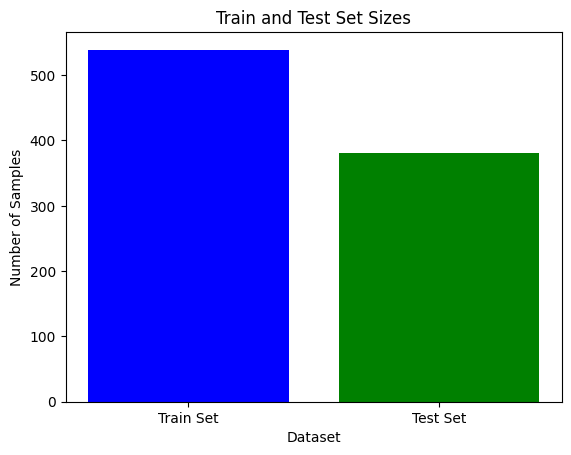

In [ ]:
# Create a bar plot
sizes = [df_train.shape[0], df_test.shape[0]]
labels = ['Train Set', 'Test Set']
plt.bar(labels, sizes, color=['blue', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Train and Test Set Sizes')
plt.show()

In [ ]:
df_test.head()

,pid,disease,mode,device,filename,split
0,101,URTI,sc,Meditron,101_1b1_Pr_sc_Meditron,test
1,101,URTI,sc,Meditron,101_1b1_Al_sc_Meditron,test
2,102,Healthy,sc,Meditron,102_1b1_Ar_sc_Meditron,test
3,104,COPD,sc,Litt3200,104_1b1_Lr_sc_Litt3200,test
4,104,COPD,sc,Litt3200,104_1b1_Ar_sc_Litt3200,test


In [ ]:
source_dirs = "/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files"
WORK = "work"
TEST_AUDIO = WORK + '/' + 'processed_audios/test'
TRAIN_AUDIO = WORK + '/' + 'processed_audios/train'
TEST_IMG = WORK + '/' + 'images/test'
TRAIN_IMG = WORK + '/' + 'images/train'

for folder in [WORK, TEST_AUDIO, TRAIN_AUDIO, TEST_IMG, TRAIN_IMG]:
  Path(folder).mkdir(exist_ok = True, parents = True)

In [ ]:
dataset = 'icbhi'
dir = "/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database"
batch_size = 32
num_workers = 4

class_split = 'diagnosis'
n_cls = 3
cls_list = ['healthy', 'chronic_diseases', 'non-chronic_diseases']
test_fold = 'official'
weighted_sampler = True # weighted sampler inversly proportional to class ratio
sthetho_id = 1 # stethoscope device id, use only when finetuning on each stethoscope data
sample_rate = 16000
max_len = 6
nfft = 1024
n_mels = 128
concat_aug_scale =0 #to control the number (scale) of concatenation-based augmented samples
pad_types = 'repeat'
resz =1
raw_augment = 0 # control how many number of augmented raw audio samples
blank_region_clip = False #remove the blank region, high frequency region
specaug_policy = 'icbhi_ast_sup'
specaug_mask = 'mean'


# parameters for spectrograms
sample_rate = sample_rate
desired_length = max_len
pad_types = pad_types
nfft = nfft
hop = nfft // 2
n_mels = n_mels
f_min = 50
f_max = 2000
dump_images = False

In [ ]:
import soundfile as sf

def processed_audio_files(data, src_dir, des_dir,split, desired_len=6, sample_rate = sample_rate):
    segments_data = []
    file_processed =0

    for index, row in data.iterrows():
      pid = row['pid']
      disease= row['disease']
      filename = row['filename']
      audio, sr = librosa.load(os.path.join(src_dir, filename + '.wav'), sr = sample_rate)


      desired_len_samples = int(desired_len * sample_rate)
      overlap_samples = desired_len_samples // 2

      # Segment the audio with overlap
      start = 0
      segment_id = 0
      while start + desired_len_samples <= len(audio):
          segment = audio[start:start + desired_len_samples]
          save_path = os.path.join(des_dir, f"{filename}_{segment_id}.wav")
          sf.write(file=save_path, data=segment, samplerate=sample_rate)

          segments_data.append({
              'pid': pid,
              'filename': f"{filename}_{segment_id}.wav",
              'disease': disease
          })
          start += desired_len_samples- overlap_samples
          segment_id += 1

      if start < len(audio):
          remaining_samples = len(audio) - start
          repeat_count = int((desired_len_samples - remaining_samples) / remaining_samples) + 1
          remaining_segment = audio[start:]
          repeated_segment = np.tile(remaining_segment, repeat_count)
          segment = repeated_segment[:desired_len_samples]
          save_path = os.path.join(des_dir, f"{filename}_{segment_id}.wav")
          sf.write(file=save_path, data=segment, samplerate=sample_rate)



          segments_data.append({
              'pid': pid,
              'filename': f"{filename}_{segment_id}.wav",
              'disease': disease
          })
          segment_id += 1

    segments_df = pd.DataFrame(segments_data)

    return segments_df

In [ ]:
df_train_processed = processed_audio_files(df_train, path, TRAIN_AUDIO, 'train', desired_length,sample_rate = sample_rate )
df_test_processed = processed_audio_files(df_test, path, TEST_AUDIO, 'test', desired_length, sample_rate = sample_rate)

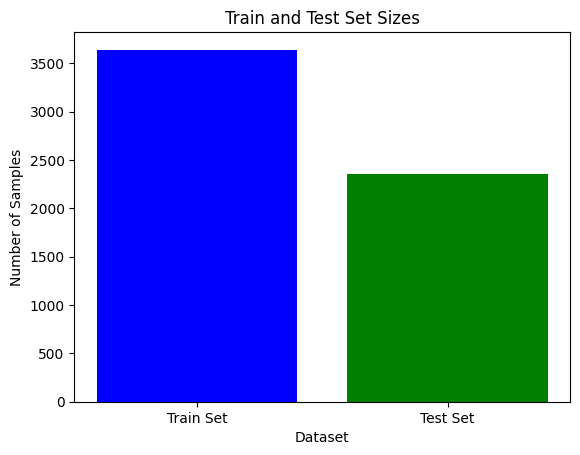

In [ ]:
# Create a bar plot
sizes = [df_train_processed.shape[0], df_test_processed.shape[0]]
labels = ['Train Set', 'Test Set']
plt.bar(labels, sizes, color=['blue', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Train and Test Set Sizes')
plt.show()

In [ ]:
disease_class_mapping = {
    'Asthma': 'Chronic Diseases',
    'Bronchiectasis': 'Chronic Diseases',
    'COPD': 'Chronic Diseases',
    'Healthy': 'Healthy',
    'LRTI': 'Non-Chronic Diseases',
    'Pneumonia': 'Non-Chronic Diseases',
    'URTI': 'Non-Chronic Diseases',
    'Bronchiolitis': 'Non-Chronic Diseases'
}

In [ ]:
df_train_processed.disease = df_train_processed.disease.apply(lambda x: disease_class_mapping[x])
df_test_processed.disease = df_test_processed.disease.apply(lambda x: disease_class_mapping[x])

In [ ]:
disease_labels = np.unique(df_train_processed.disease)
num_classes = len(disease_labels)
print("Disease classes are ",disease_labels)

Disease classes are  ['Chronic Diseases' 'Healthy' 'Non-Chronic Diseases']


In [ ]:
label_mapping = {'Healthy': 0, 'Chronic Diseases': 1, 'Non-Chronic Diseases': 2}

df_train_processed['disease'] = df_train_processed['disease'].map(label_mapping)
df_test_processed['disease'] = df_test_processed['disease'].map(label_mapping)

In [ ]:
import os
import librosa
from torch.utils.data import Dataset
import numpy as np
import soundfile
import transformers
from transformers import AutoFeatureExtractor, AutoProcessor
import torchaudio, torch
from torchvision import transforms

# import wandb

from torch.optim import AdamW
from torch.utils.data import DataLoader
import warnings
warnings.simplefilter("ignore", UserWarning)
import time
import datetime
import copy

# processor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593", max_length= desired_length*100)

In [ ]:
import torch
import torch.nn as nn
import torchaudio
from torchaudio import transforms as T


class SpecAugment(torch.nn.Module):
    def __init__(self, freq_mask=20, time_mask= 50, freq_stripes=2, time_stripes=2, p=1.0):
        super().__init__()
        self.p = p
        self.freq_mask = freq_mask
        self.time_mask = time_mask
        self.freq_stripes = freq_stripes
        self.time_stripes = time_stripes
        self.specaugment = nn.Sequential(
            *[T.FrequencyMasking(freq_mask_param=self.freq_mask, iid_masks=True) for _ in range(self.freq_stripes)],
            *[T.TimeMasking(time_mask_param=self.time_mask, iid_masks=True) for _ in range(self.time_stripes)],
            )

    def forward(self, audio):
        # if not isinstance(audio, torch.Tensor):
        #       audio = torch.tensor(audio)
        if self.p > torch.randn(1):
            return self.specaugment(audio)
        else:
            return audio

In [ ]:
def get_score(predictions, labels, num_classes = 3):
    TP = [0]*num_classes
    GT = [0]*num_classes
    for idx in range(num_classes):
        TP[idx]+= np.sum(np.logical_and(predictions == idx, labels == idx)).astype(int)
        GT[idx]+= np.sum((labels == idx)).astype(int)

    se = sum(TP[1:])/sum(GT[1:])
    sp = TP[0]/GT[0]
    icbhi_score = (se+sp)/2
    print(TP)
    print(GT)
    return se, sp, icbhi_score

In [ ]:
import os
import librosa
from torch.utils.data import Dataset
import numpy as np
import soundfile
from transformers import AutoFeatureExtractor
import random
from torchvision import transforms
import torch

class ICBHIDataset(Dataset):

    def __init__(self, data_path, max_len_AST, split, transform, apply_SpecAug=False, samples_per_class=2, threshold=500):
        if split not in ("train", "test"):
            raise ValueError(f"`train` arg ({split}) must be a bool or train/test.")

        self.data_path = data_path
        self.max_len_AST = max_len_AST
        self.split = split
        self.apply_SpecAug = apply_SpecAug
        self.transform = transform
        self.samples_per_class = samples_per_class
        self.threshold = threshold

        self.x, self.y = self.get_data()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        audio = self.x[index]
        audio = self.transform(audio)
        if audio.size(0) == 1:  # Check if the first dimension is 1
            audio = audio.squeeze(0)
        return audio, self.y[index]

    def _add_noise(self, audio):
        noise_amp = 0.035 * np.random.uniform() * np.amax(audio)
        noisy_audio = audio + noise_amp * np.random.normal(size=audio.shape[0])
        return noisy_audio

    def _mix_samples(self, audio1, audio2):
        mix_ratio = np.random.uniform(0.3, 0.7)  # Mix with a random ratio
        mixed_audio = mix_ratio * audio1 + (1 - mix_ratio) * audio2
        return mixed_audio

    def get_data(self):

        if self.split == 'train':
            fold = os.path.join(self.data_path, 'train')
            df_temp = df_train_processed
        else:
            fold = os.path.join(self.data_path, 'test')
            df_temp = df_test_processed

        processor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593", max_length=self.max_len_AST)

        x, y = [], []

        class_dict = {class_id: [] for class_id in df_temp['disease'].unique()}
        for index, row in df_temp.iterrows():
            filename = row['filename']
            class_id = row['disease']
            pathh = os.path.join(fold, filename)
            wav, sampling_rate = librosa.load(pathh, sr=sample_rate)

            if len(wav.shape) > 1:
                wav = wav[:, 0]

            wav = librosa.resample(wav, orig_sr=sampling_rate, target_sr=sample_rate)
            spec = processor(wav, sampling_rate=sample_rate, return_tensors='pt')['input_values'].squeeze(0)
            spec = (spec - spec.min()) / (spec.max() - spec.min())

            x.append(spec)
            y.append(class_id)
            class_dict[class_id].append(spec)

            # if self.apply_SpecAug:  # Apply SpecAugment to original data only
            #     spec = self.spec_augment(spec)
            # x.append(spec)
            # y.append(class_id)

            if self.split == 'train':
                wav = self._add_noise(wav)
                spec = processor(wav, sampling_rate=sample_rate, return_tensors='pt')['input_values'].squeeze(0)
                spec = (spec - spec.min()) / (spec.max() - spec.min())
                x.append(spec)
                y.append(class_id)

        if self.split == 'train':
            for class_id, samples in class_dict.items():
                if len(samples) < self.threshold:
                    for _ in range(self.samples_per_class):
                        if len(samples) > 1:
                            sample1, sample2 = random.sample(samples, 2)
                            mixed_sample = self._mix_samples(sample1, sample2)
                            x.append(mixed_sample)
                            y.append(class_id)

        return np.array(x), np.array(y)

    def spec_augment(self, spec):
        spec_augment = SpecAugment()
        spec = spec_augment(spec.unsqueeze(0))
        return spec.squeeze(0)


In [ ]:
from transformers import ASTModel
import torch.nn as nn


class AST(nn.Module):
    def __init__(self, max_length: int, num_classes: int, final_output: str, model_ckpt="MIT/ast-finetuned-audioset-10-10-0.4593"):
        super().__init__()

        assert final_output in ['CLS','ALL'], ("Classification can be only applied to the [CLS] token or to the entire sequence!")

        self.model = ASTModel.from_pretrained(model_ckpt, max_length=max_length, ignore_mismatched_sizes=True)
        self.model_config = self.model.config
        self.final_output = final_output

        self.classification_head = nn.Linear(self.model_config.hidden_size, num_classes)

    def forward(self, x):

        hidden_states = self.model(x)[0]

        if self.final_output == 'CLS':
            return self.classification_head(hidden_states[:,0])
        else:
            return self.classification_head(hidden_states.mean(dim=1))

    def forward_tsne(self,x):
        hidden_states = self.model(x)[0]
        return hidden_states[:,0], hidden_states.mean(dim=1)

In [ ]:
import torch

def train_one_epoch(model, loader, optimizer, scheduler, device, criterion):
    model.train(True)

    loss = 0.
    correct = 0
    total = 0
    TP, GT = [0.0] * num_classes, [0.0] * num_classes
    for idx_batch, (x, y) in enumerate(loader):

        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        outputs = model(x)

        loss_batch = criterion(outputs,y)
        loss += loss_batch.detach().item()
        total += len(x)
        correct += (y==outputs.argmax(dim=-1)).sum().item()
        preds = outputs.argmax(dim=-1)
        for idx in range(len(TP)):
          TP[idx] += torch.logical_and((preds==idx),(y==idx)).sum().item()
          GT[idx] += (y==idx).sum().item()


        loss_batch.backward()
        optimizer.step()
        scheduler.step()

    loss /= len(loader)
    accuracy = correct/total

    se = sum(TP[1:]) / sum(GT[1:]) if sum(GT[1:]) != 0 else 0.0
    sp = TP[0] / GT[0] if GT[0] != 0 else 0.0

    icbhi_score = (se+sp)/2

    return loss, accuracy, sp, se, icbhi_score

def eval_one_epoch(model, loader, device, criterion):

    loss = 0.
    correct = 0
    total = 0
    TP, GT = [0.0] * num_classes, [0.0] * num_classes
    y_pred =[]

    model.eval()

    with torch.inference_mode():
        for idx_batch, (x,y) in enumerate(loader):
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)

            loss_batch = criterion(outputs, y)
            loss += loss_batch.detach().item()

            total += len(x)
            correct += (y==outputs.argmax(dim=-1)).sum().item()
            preds = outputs.argmax(dim=-1)

            for idx in range(len(TP)):
              TP[idx] += torch.logical_and((preds==idx),(y==idx)).sum().item()
              GT[idx] += (y==idx).sum().item()

            y_pred.append(preds.cpu())

        y_pred = torch.cat(y_pred, dim=0)
        loss /= len(loader)
        accuracy = correct/total
        se = sum(TP[1:]) / sum(GT[1:]) if sum(GT[1:]) != 0 else 0.0
        sp = TP[0] / GT[0] if GT[0] != 0 else 0.0
        icbhi_score = (se+sp)/2


    return loss, accuracy,sp, se, icbhi_score, y_pred

In [ ]:
from collections import Counter

def class_calculate():

  # total_class = np.concatenate((df_train_processed.disease.values, df_test_processed.disease.values))
  total_class = ((df_train_processed.disease.values))
  class_counts = Counter(total_class)

  return class_counts

In [ ]:
def main(seed, data_path, dataset_name, method, model_ckpt_AST, save_best_ckpt, output_path, device,weighted_sampler =False, weighted_loss = True,
         num_workers = 8,lr_linear = 0.00015, final_output= 'ALL', weight_decay =0.00001):
  torch.manual_seed(seed)
  np.random.seed(seed)
  start_time = time.time()

  accuracy_folds = []
  train_losses , train_se_scores, train_sp_scores , train_icbhi_scores , train_acc_scores = [] , [], [], [], []
  val_losses, val_se_scores, val_sp_scores , val_icbhi_scores , val_acc_scores = [] , [], [], [], []
  train_transform = [transforms.ToTensor()]
  test_transform = [transforms.ToTensor()]

  train_transform = transforms.Compose(train_transform)
  test_transform = transforms.Compose(test_transform)

  train_data = ICBHIDataset(data_path, max_len_AST,
                                'train', transform = train_transform,
                                apply_SpecAug=True,
                                samples_per_class=64)
  test_data = ICBHIDataset(data_path, max_len_AST, 'test', transform = test_transform)

  if weighted_sampler:
      class_counts = class_calculate()
      # Calculate total number of samples
      total_samples = sum(class_counts.values())
      reciprocal_weights = torch.zeros(num_classes, dtype = torch.float32)
      for class_label, count in class_counts.items():
        reciprocal_weights[class_label] = (count / total_samples)*100

      reciprocal_weights = (1.0/reciprocal_weights)
      sampler = torch.utils.data.sampler.WeightedRandomSampler(reciprocal_weights, len(train_data))
  else:
      sampler = None


  train_loader = DataLoader(train_data, batch_size= batch_size, shuffle = True, num_workers= num_workers, pin_memory= True, drop_last= False)
  test_loader = DataLoader(test_data, batch_size= batch_size, shuffle= False, num_workers= num_workers, pin_memory= True, drop_last= False,)


  model = AST(max_length= max_len_AST, num_classes= num_classes, final_output= final_output, model_ckpt= model_ckpt_AST).to(device)

  model.model.requires_grad_(False)

  for param in model.model.encoder.layer[-2:]:
    param.requires_grad_(True)

  # LN is trainable.
  model.model.layernorm.requires_grad_(True)
  lr = lr_linear



  # PRINT MODEL PARAMETERS
  n_parameters = sum(p.numel() for p in model.parameters())
  print('Number of params of the model:', n_parameters)

  n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

  print('Number of trainable params of the model:', n_parameters)

  print(model)


  optimizer = AdamW([{'params': model.model.parameters()}, {'params': model.classification_head.parameters(),'lr': 1e-5}],lr= lr,
                              betas= (0.9,0.98), eps= 1e-8, weight_decay= weight_decay )

  if not weighted_loss:
      weights = None
      criterion = torch.nn.CrossEntropyLoss()
  else:
    class_counts = class_calculate()
    total_samples = sum(class_counts.values())
    weights = torch.zeros(num_classes,dtype=torch.float32)
    for class_label, count in class_counts.items():
        weights[class_label] = count/total_samples
    weights = 1.0/weights
    weights = weights/total_samples

    criterion = torch.nn.CrossEntropyLoss(weight=weights)

  criterion.to(device)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader)*(epochs))

  print(f"Start training for {epochs} epochs")

  best_acc = 0.0
  best_sc =0.0

  for epoch in range(epochs):
    train_loss, train_acc, train_sp, train_se, train_sc= train_one_epoch(model, train_loader, optimizer, scheduler, device, criterion)
    train_losses.append(train_loss); train_se_scores.append(train_se); train_sp_scores.append(train_sp); train_icbhi_scores.append(train_sc); train_acc_scores.append(train_acc)

    val_loss, val_acc,val_sp, val_se, val_sc, y_pred = eval_one_epoch(model, test_loader, device, criterion)
    val_losses.append(val_loss); val_se_scores.append(val_se); val_sp_scores.append(val_sp); val_icbhi_scores.append(val_sc); val_acc_scores.append(val_acc)

    if val_sc > best_sc:
        best_sc = val_sc
        best_acc = val_acc
        best_params = model.state_dict()

        if save_best_ckpt:
          torch.save(best_params, os.path.join(output_path, "best_model.pt"))

    current_lr = optimizer.param_groups[0]['lr']

    # Print the metrics to the console
    # print(f"Epoch {epoch}: Train Loss: {train_loss}, Valid Loss: {val_loss},  Train Score: {train_sc}, Valid Score: {val_sc}, Train Accuracy: {train_acc}, Valid Accuracy: {val_acc},  Learning Rate: {current_lr},")
    print(f"Epoch {epoch}:")
    print(f"  Train Loss: {train_loss}, Train Accuracy: {train_acc}, Train SP: {train_sp}, Train SE: {train_se}, Train SC: {train_sc}, Learning Rate: {current_lr}")
    print(f"  Valid Loss: {val_loss}, Valid Accuracy: {val_acc}, Valid SP: {val_sp}, Valid SE: {val_se}, Valid SC: {val_sc}")
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Epoch time {}'.format(total_time_str))

  total_time = time.time() - start_time
  total_time_str = str(datetime.timedelta(seconds=int(total_time)))
  print('Training time {}'.format(total_time_str))
  return train_losses, val_losses, train_se_scores, train_sp_scores, train_icbhi_scores, train_acc_scores, val_se_scores, val_sp_scores, val_icbhi_scores, val_acc_scores

In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

directory = "/content/checkpoint"
if not os.path.exists(directory):
    os.makedirs(directory)

Using device: cuda


In [ ]:
data_path = "/content/work/processed_audios"
dataset_name = 'ICBHI'
method = 'linear'
seed = 10
model_ckpt_AST = 'MIT/ast-finetuned-audioset-10-10-0.4593'
save_best_ckpt = True
output_path = "/content/checkpoint"
max_len_AST = desired_length*100
num_classes = 3
batch_size = 64
epochs = 3

In [ ]:
history = main(seed, data_path, dataset_name, method, model_ckpt_AST, save_best_ckpt, output_path, device)

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTModel were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- audio_spectrogram_transformer.embeddings.position_embeddings: found shape torch.Size([1, 1214, 768]) in the checkpoint and torch.Size([1, 710, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of params of the model: 85802499
Number of trainable params of the model: 14179587
AST(
  (model): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
      

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0:
  Train Loss: 0.6725187256675342, Train Accuracy: 0.7594441446303292, Train SP: 0.7142857142857143, Train SE: 0.7612170499158721, Train SC: 0.7377513821007933, Learning Rate: 0.00011250000000000004
  Valid Loss: 0.31419840298995777, Valid Accuracy: 0.9341546304163126, Valid SP: 0.9019607843137255, Valid SE: 0.9356127886323268, Valid SC: 0.9187867864730261
Epoch time 0:10:07
Epoch 1:
  Train Loss: 0.31460275552396116, Train Accuracy: 0.8934160820291419, Train SP: 0.9035714285714286, Train SE: 0.8930173864273696, Train SC: 0.898294407499399, Learning Rate: 3.749999999999996e-05
  Valid Loss: 0.49161207163391785, Valid Accuracy: 0.9413763806287171, Valid SP: 0.5784313725490197, Valid SE: 0.9578152753108348, Valid SC: 0.7681233239299272
Epoch time 0:18:50
Epoch 2:
  Train Loss: 0.2080581568759577, Train Accuracy: 0.9268753372908797, Train SP: 0.9357142857142857, Train SE: 0.9265283230510376, Train SC: 0.9311213043826616, Learning Rate: 0.0
  Valid Loss: 0.7869235117372276, Valid A

### Save Model in Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
local_model_path = '/content/checkpoint/best_model.pt'

drive_checkpoint_path = '/content/drive/My Drive/checkpoint/'

drive_model_path = os.path.join(drive_checkpoint_path, "best_model_of_AST_of_length6_2encoder_train_with_noise_add_mixup_lr_00015.pt")


if not os.path.exists(drive_checkpoint_path):
    os.makedirs(drive_checkpoint_path)

# Copy the file to Google Drive
shutil.copyfile(local_model_path, drive_model_path)

'/content/drive/My Drive/checkpoint/best_model_of_AST_of_length6_2encoder_train_with_noise_add_mixup_lr_00015.pt'

In [ ]:
def load_test_data(data_path, max_len_AST,batch_size, num_workers=8):
  test_transform = [transforms.ToTensor()]
  test_transform = transforms.Compose(test_transform)
  test_data = ICBHIDataset(data_path, max_len_AST, 'test', transform = test_transform)
  test_loader = DataLoader(test_data, batch_size= batch_size, shuffle= False, num_workers= num_workers, pin_memory= True, drop_last= False)
  return test_loader
test_loader = load_test_data(data_path, max_len_AST, batch_size)

In [ ]:
# drive_model_path = '/content/drive/My Drive/checkpoint/best_model_of_AST_of_length6_2encoder_train_with_noise_add_mixup2.pt'

drive_model_path = '/content/checkpoint/best_model.pt'

loaded_checkpoint = torch.load(drive_model_path)


best_model = AST(max_length=max_len_AST, num_classes=num_classes, final_output='ALL', model_ckpt=model_ckpt_AST).to(device)
best_model.load_state_dict(torch.load(drive_model_path))


Some weights of ASTModel were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- audio_spectrogram_transformer.embeddings.position_embeddings: found shape torch.Size([1, 1214, 768]) in the checkpoint and torch.Size([1, 710, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)
test_loss, test_acc, test_sp, test_se, test_sc, y_pred = eval_one_epoch(best_model, test_loader, device, criterion)

In [ ]:
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}, Test Specificity {test_sp}, Test Sensitivity: {test_se}, Test Score {test_sc}")

Test Loss: 0.18263134657329805, Test Accuracy: 0.9341546304163126, Test Specificity 0.9019607843137255, Test Sensitivity: 0.9356127886323268, Test Score 0.9187867864730261


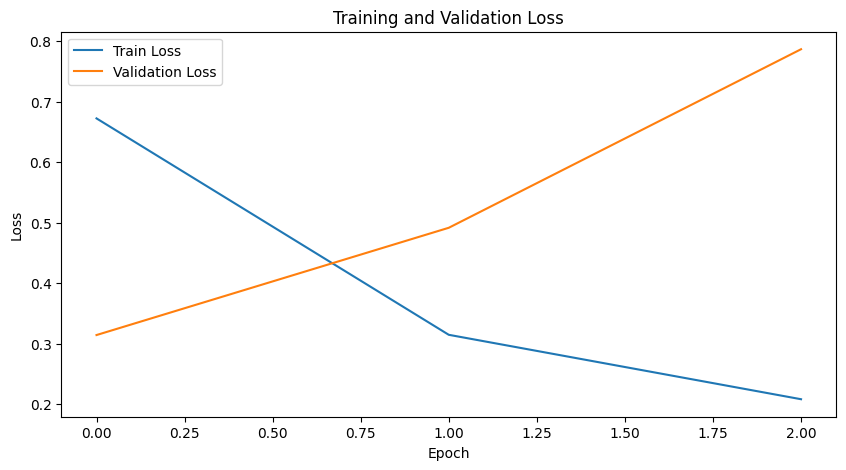

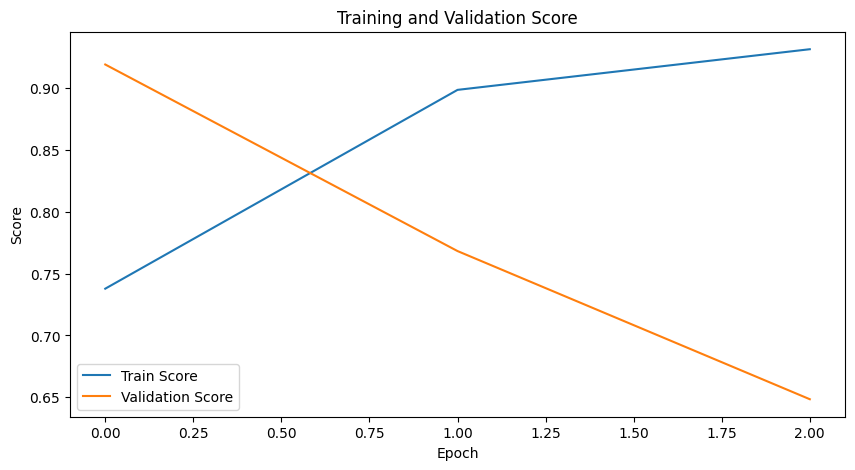

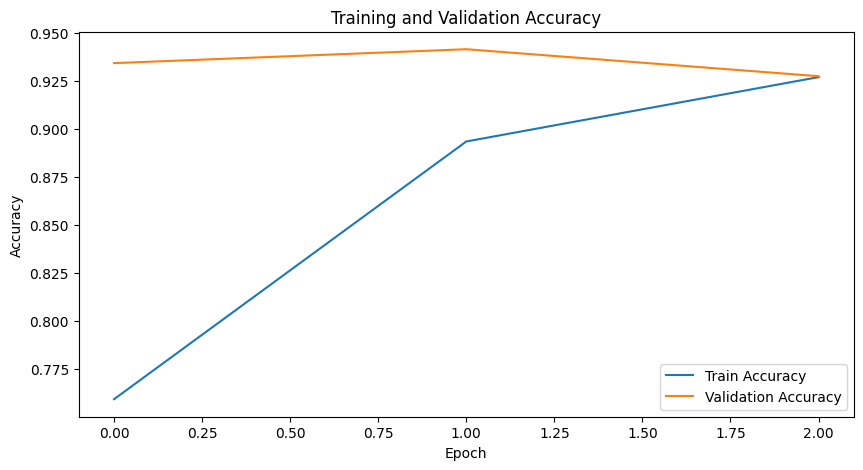

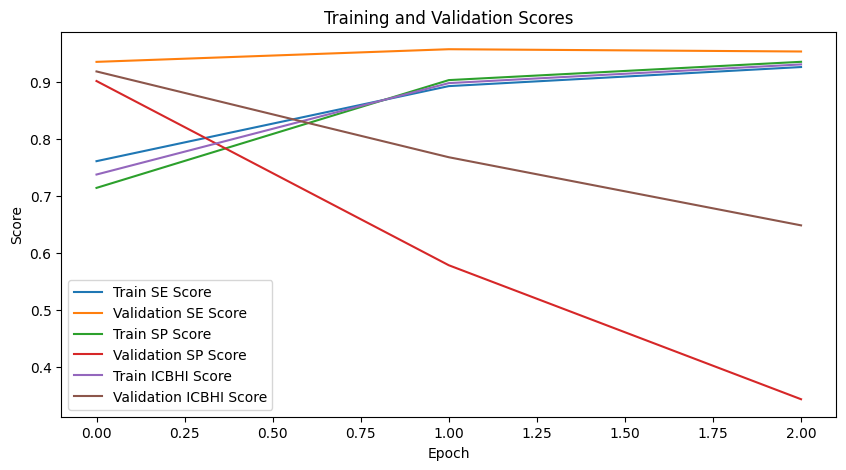

In [ ]:
import matplotlib.pyplot as plt

# Extract data from history
train_losses, val_losses, train_se_scores, train_sp_scores, train_icbhi_scores, train_acc_scores, val_se_scores, val_sp_scores, val_icbhi_scores, val_acc_scores = history

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
print()

plt.figure(figsize=(10, 5))
plt.plot(train_icbhi_scores, label='Train Score')
plt.plot(val_icbhi_scores, label='Validation Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training and Validation Score')
plt.legend()
plt.show()

print()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_scores, label='Train Accuracy')
plt.plot(val_acc_scores, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

print()
# Plot scores
plt.figure(figsize=(10, 5))
plt.plot(train_se_scores, label='Train SE Score')
plt.plot(val_se_scores, label='Validation SE Score')
plt.plot(train_sp_scores, label='Train SP Score')
plt.plot(val_sp_scores, label='Validation SP Score')
plt.plot(train_icbhi_scores, label='Train ICBHI Score')
plt.plot(val_icbhi_scores, label='Validation ICBHI Score')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training and Validation Scores')
plt.legend()
plt.show()


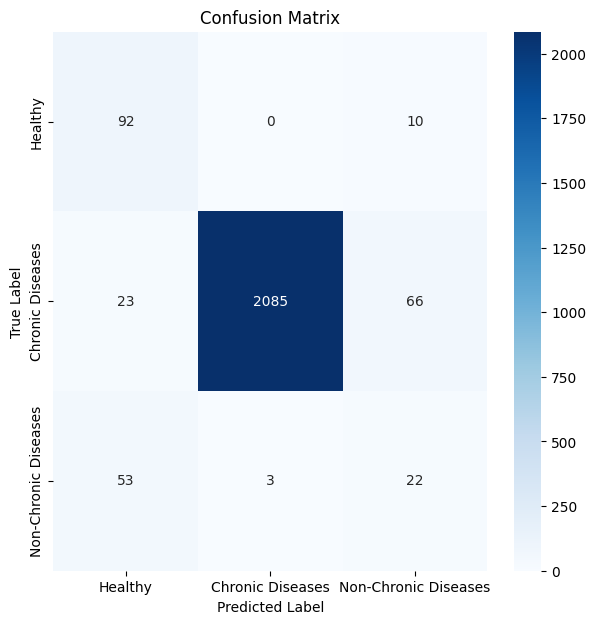

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = []
for _, labels in test_loader:
    y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred)

label_mapping = {'Healthy': 0, 'Chronic Diseases': 1, 'Non-Chronic Diseases': 2}
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
assert len(y_true) == len(y_pred), "Length of y_true and y_pred should be the same."

y_true_labels = [reverse_label_mapping[label] for label in y_true]
y_pred_labels = [reverse_label_mapping[label] for label in y_pred]

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(reverse_label_mapping.values()))
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(reverse_label_mapping.values()), yticklabels=list(reverse_label_mapping.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


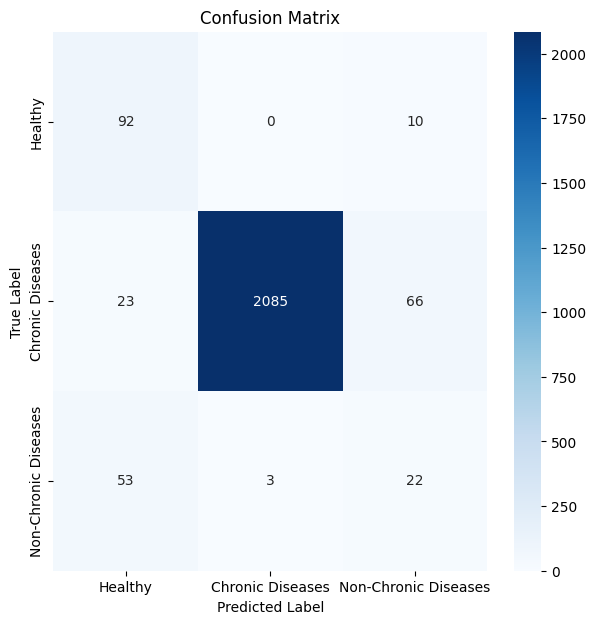

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = []
for _, labels in test_loader:
    y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred)

label_mapping = {'Healthy': 0, 'Chronic Diseases': 1, 'Non-Chronic Diseases': 2}
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
assert len(y_true) == len(y_pred), "Length of y_true and y_pred should be the same."

y_true_labels = [reverse_label_mapping[label] for label in y_true]
y_pred_labels = [reverse_label_mapping[label] for label in y_pred]

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(reverse_label_mapping.values()))
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(reverse_label_mapping.values()), yticklabels=list(reverse_label_mapping.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

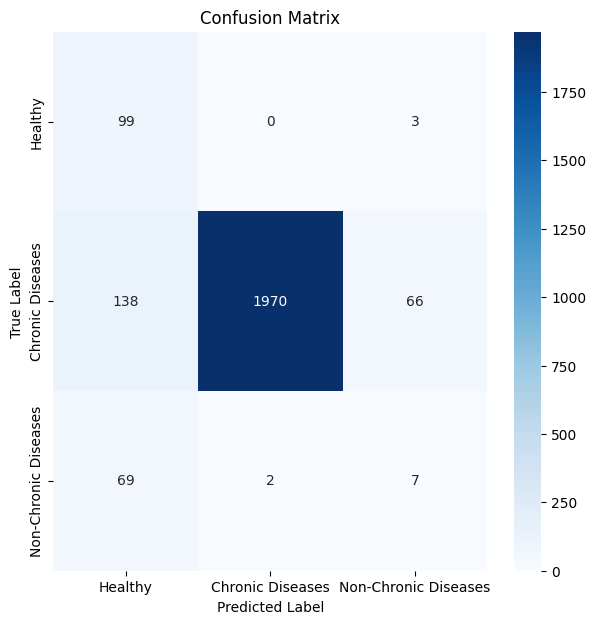

In [ ]:
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(reverse_label_mapping.values()), yticklabels=list(reverse_label_mapping.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()